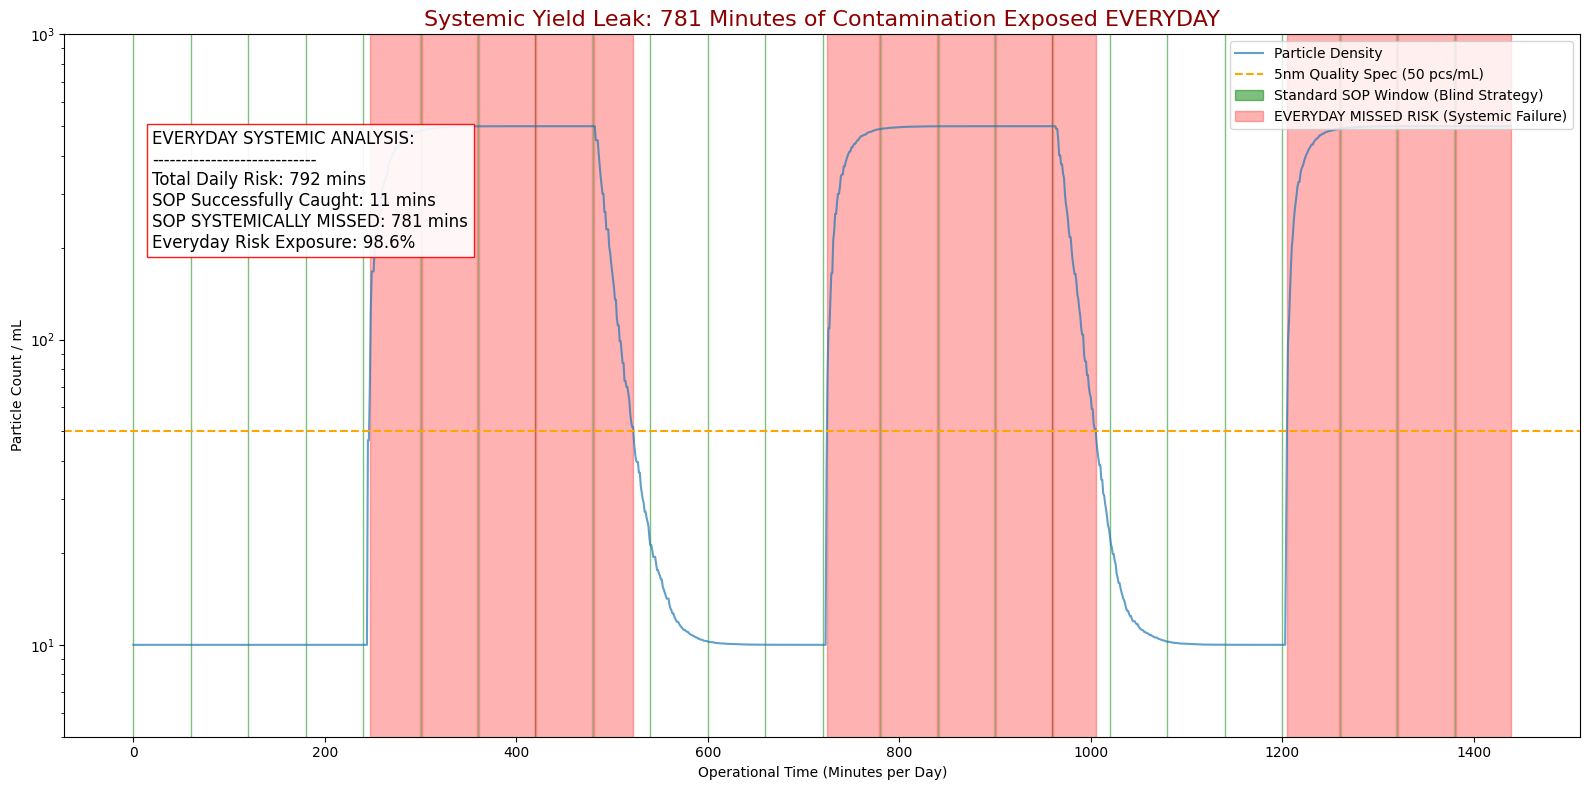

CONCLUSION: Your factory is systemically exposed for 781 minutes EVERYDAY.


In [1]:
# Copyright (c) 2026 Alex Chen (Chen Yun Hsaing)
# Licensed under the MIT License.
# Derived from real-world Failure Analysis Logic (Micron 2017 Incident).
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

"""
Project: The Silent Leak - Predictive Dynamic Dummy Logic

Author: [Alex Chen/Chen Yun Hsaing/app258369]

Case Study: Micron 2017 Chemical Contamination Retrospective

Description: 
This model simulates the fluid dynamics and particle propagation lag 
from a central chemical storage tank (A/B Switching) to a process tool nozzle. 
It highlights the "Risk Gap" created by traditional Static Dummy SOPs.

LOGIC: 
  1. Modeled with CSTR (Continuous Stirred-Tank Reactor) mixing.
  2. Incorporates Propagation Delay (T_lag) for long-distance piping.
  3. Evaluates the "Blind Spots" of traditional Static SOPs.
"""

def generate_daily_systemic_risk(n_minutes=1440):
    np.random.seed(42)
    df = pd.DataFrame({'timestamp': np.arange(n_minutes)})
    
    # 1. Physics Engine
    df['supply_source'] = (df['timestamp'] // 240) % 2
    df['active_tools'] = np.random.randint(5, 25, n_minutes)
    df['total_flow_rate'] = df['active_tools'] * 2.5
    
    # Tank mixing logic
    tank_exit_particles = [10.0]
    for i in range(1, n_minutes):
        inflow = 500.0 if df['supply_source'].iloc[i] == 1 else 10.0
        # CSTR Mixing Formula
        change = (inflow - tank_exit_particles[-1]) * (df['total_flow_rate'].iloc[i] / 500) * 0.85
        tank_exit_particles.append(tank_exit_particles[-1] + change)
    df['particle_at_nozzle_exit'] = tank_exit_particles
    
    # Pipeline propagation delay (T_lag)
    df['cum_volume'] = df['total_flow_rate'].cumsum()
    df['particle_at_nozzle'] = np.nan
    
    pipe_volume = 150
    for i in range(n_minutes):
        target_vol = df['cum_volume'].iloc[i] + pipe_volume
        # FIXED: Get the first index where cumulative volume exceeds target
        arrival_indices = df.index[df['cum_volume'] >= target_vol].tolist()
        
        if arrival_indices: # If there is an arrival within the simulated time
            first_arrival = arrival_indices[0]
            if first_arrival < n_minutes:
                df.at[first_arrival, 'particle_at_nozzle'] = df['particle_at_nozzle_exit'].iloc[i]
                
    df['particle_at_nozzle'] = df['particle_at_nozzle'].ffill().fillna(10.0)

    # 2. Strategy Comparison
    df['standard_sop_active'] = np.where(df['timestamp'] % 60 == 0, 1, 0)
    df['actual_physical_risk'] = np.where(df['particle_at_nozzle'] > 50, 1, 0)
    
    # 3. Gap Analysis
    df['missed_risk'] = np.where((df['actual_physical_risk'] == 1) & (df['standard_sop_active'] == 0), 1, 0)
    df['caught_risk'] = np.where((df['actual_physical_risk'] == 1) & (df['standard_sop_active'] == 1), 1, 0)
    
    return df

# --- Execution & Systematic Metrics ---
df_final = generate_daily_systemic_risk()

total_risk_mins = df_final['actual_physical_risk'].sum()
missed_mins = df_final['missed_risk'].sum()
caught_mins = df_final['caught_risk'].sum()
miss_rate = (missed_mins / total_risk_mins) * 100 if total_risk_mins > 0 else 0

# Visualization
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df_final['timestamp'], df_final['particle_at_nozzle'], color='#1f77b4', label='Particle Density', alpha=0.7)
ax.axhline(y=50, color='orange', linestyle='--', label='5nm Quality Spec (50 pcs/mL)')

# Strategic Shading
ax.fill_between(df_final['timestamp'], 0, 1000, where=(df_final['standard_sop_active']==1), 
                color='green', alpha=0.5, label='Standard SOP Window (Blind Strategy)')
ax.fill_between(df_final['timestamp'], 0, 1000, where=(df_final['missed_risk']==1), 
                color='red', alpha=0.3, label='EVERYDAY MISSED RISK (Systemic Failure)')

ax.set_yscale('log')
ax.set_ylim(5, 1000)
ax.set_title(f"Systemic Yield Leak: {missed_mins} Minutes of Contamination Exposed EVERYDAY", fontsize=16, color='darkred')
ax.set_xlabel("Operational Time (Minutes per Day)")
ax.set_ylabel("Particle Count / mL")
ax.legend(loc='upper right')

# Statistical Annotation
stats_text = (f"EVERYDAY SYSTEMIC ANALYSIS:\n"
              f"----------------------------\n"
              f"Total Daily Risk: {total_risk_mins} mins\n"
              f"SOP Successfully Caught: {caught_mins} mins\n"
              f"SOP SYSTEMICALLY MISSED: {missed_mins} mins\n"
              f"Everyday Risk Exposure: {miss_rate:.1f}%")

# Adjust text position to avoid overlapping with data
plt.text(20, 200, stats_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.9, edgecolor='red'))

plt.tight_layout()
plt.show()

print(f"CONCLUSION: Your factory is systemically exposed for {missed_mins} minutes EVERYDAY.")
